# III 5.11
Постройте наилучшую среднеквадратическую линейную аппроксимацию для функции
$f(x) = \sin x \ при \ x \in [0, \pi/2].$

Определим скалярное произведение как
$\langle f,g\rangle=\int_0^{\pi/2} f(x)g(x)\,dx$

In [16]:
import numpy as np

a, b = 0.0, 0.5*np.pi
x = np.linspace(a, b, 4001)

def trapz_integral(y, x):
    return np.trapezoid(y, x)

def dot_product(f_vals, g_vals, x):
    return trapz_integral(f_vals * g_vals, x)

## Построение системы нормальных уравнений
Базис: $g_1(x)=1$, $g_2(x)=x$.  
Матрица Грама $M$: $M_{ij}=\langle g_i, g_j\rangle$.  
Правая часть $b$: $b_i=\langle g_i, f\rangle$, где $f(x)=\sin x$

In [17]:
f_vals = np.sin(x)
basis = [lambda x: np.ones_like(x), lambda x: x]

# Соберём M и b
n = len(basis)
M = np.zeros((n, n))
b = np.zeros(n)

g_cache = [basis[i](x) for i in range(n)]

for i in range(n):
    gi = g_cache[i]
    b[i] = dot_product(gi, f_vals, x)
    for j in range(n):
        gj = g_cache[j]
        M[i, j] = dot_product(gi, gj, x)

M, b

(array([[1.57079633, 1.23370055],
        [1.23370055, 1.29192824]]),
 array([0.99999999, 1.00000001]))

Решаем $M\,\alpha = \text{b}$. Получаем $\alpha_1,\alpha_2$ и полином $p(x)=\alpha_1+\alpha_2 x$

In [18]:
alpha = np.linalg.solve(M, b)
alpha_1, alpha_2 = alpha  # p(x) = alpha_1 + alpha_2*x

alpha_1, alpha_2

(np.float64(0.1147706833104306), np.float64(0.6644388861549194))

Посчитаем:
- норму ошибки $\|f-p\| = \big(\int_0^{\pi/2}(f-p)^2\,dx\big)^{1/2}$;
- среднеквадратичную ошибку RMSE и построим график.


In [19]:
import matplotlib.pyplot as plt

p_vals = alpha_1 + alpha_2*x
err_sq = trapz_integral((f_vals - p_vals)**2, x)
err = np.sqrt(err_sq)

rmse = np.sqrt(np.mean((f_vals - p_vals)**2))

alpha_1, alpha_2, err, rmse

(np.float64(0.1147706833104306),
 np.float64(0.6644388861549194),
 np.float64(0.07866757189774012),
 np.float64(0.06279790167535032))

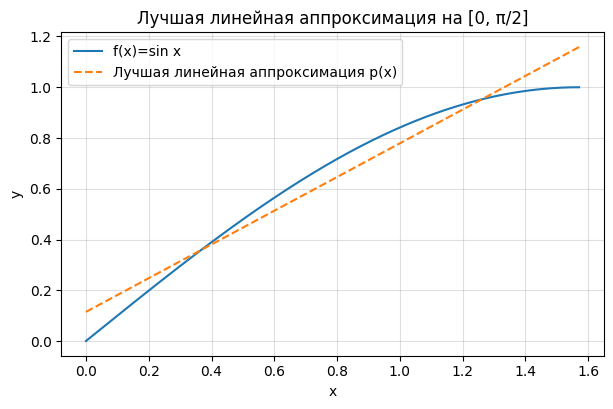

In [20]:
plt.figure(figsize=(7,4.2))
plt.plot(x, f_vals, label='f(x)=sin x')
plt.plot(x, p_vals, '--', label='Лучшая линейная аппроксимация p(x)')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.grid(True, alpha=0.4)
plt.title('Лучшая линейная аппроксимация на [0, π/2]')
plt.show()


Коэффициенты $p(x)=\alpha_1 + \alpha_2 x$ см выше.
$$
\alpha_2 = \frac{24(4-\pi)}{\pi^3} \approx 0.664,\qquad
\alpha_1 = \frac{8(\pi-3)}{\pi^2} \approx 0.115.
$$
Найденная аппроксимация и график подтверждают хорошее совпадение на $[0,\pi/2]$

Ошибка: 0.078

# III.5.12 — МНК-аппроксимация численности населения США

### Данные

In [21]:
import numpy as np
import pandas as pd

years = np.array([1910,1920,1930,1940,1950,1960,1970,1980,1990,2000], dtype=float)
pop   = np.array([92228496,106021537,123202624,132164569,151325798,179323175,
                  203211926,226545805,248709873,281421906], dtype=float)

true_2010 = 308_745_538

df = pd.DataFrame({'Год': years.astype(int), 'Население': pop.astype(int)})

from IPython.display import display
display(df)
df

,Год,Население
0,1910,92228496
1,1920,106021537
2,1930,123202624
3,1940,132164569
4,1950,151325798
5,1960,179323175
6,1970,203211926
7,1980,226545805
8,1990,248709873
9,2000,281421906


,Год,Население
0,1910,92228496
1,1920,106021537
2,1930,123202624
3,1940,132164569
4,1950,151325798
5,1960,179323175
6,1970,203211926
7,1980,226545805
8,1990,248709873
9,2000,281421906


In [22]:
# базисы
import numpy as np

def design_matrix(x, deg, transform):
    z = transform(x)
    cols = [np.ones_like(z)]
    for k in range(1, deg+1):
        cols.append(z**k)
    return np.column_stack(cols)

def fit_poly_ls(x, y, deg, transform):
    A = design_matrix(x, deg, transform)
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    y_hat = A @ coef
    F = float(np.sum((y - y_hat)**2))
    rmse = float(np.sqrt(np.mean((y - y_hat)**2)))
    condA = float(np.linalg.cond(A))
    return coef, y_hat, F, rmse, condA

def make_predictor(coef, transform):
    def pred(x):
        A = design_matrix(np.atleast_1d(x), len(coef)-1, transform)
        return (A @ coef).squeeze()
    return pred

t_b = lambda x: (x - 1910.0)
t_g = lambda x: (x - 1955.0)/45.0


## Оценки для N = 2, 3, 4, 5

In [23]:
results = {'(б) u=x-1910':{}, '(г) z=(x-1955)/45':{}}
for label, tf in [('(б) u=x-1910', t_b), ('(г) z=(x-1955)/45', t_g)]:
    for N in range(2, 6):
        coef, y_hat, F, rmse, condA = fit_poly_ls(years, pop, N, tf)
        results[label][N] = {'coef':coef, 'F':F, 'rmse':rmse, 'condA':condA, 'pred': make_predictor(coef, tf)}

results

{'(б) u=x-1910': {2: {'coef': array([9.24720613e+07, 1.16630311e+06, 1.03367964e+04]),
   'F': 84923424973180.4,
   'rmse': 2914162.4006424285,
   'condA': 9745.206499559066,
   'pred': <function __main__.make_predictor.<locals>.pred(x)>},
  3: {'coef': array([ 9.34851591e+07,  9.80970530e+05,  1.57641061e+04, -4.02022941e+01]),
   'F': 79931230890524.44,
   'rmse': 2827211.1857893537,
   'condA': 900514.1984845705,
   'pred': <function __main__.make_predictor.<locals>.pred(x)>},
  4: {'coef': array([ 9.30679111e+07,  1.15482388e+06,  6.00900143e+03,  1.33651057e+02,
          -9.65851952e-01]),
   'F': 78394458177873.19,
   'rmse': 2799901.037141727,
   'condA': 80236734.31930779,
   'pred': <function __main__.make_predictor.<locals>.pred(x)>},
  5: {'coef': array([ 9.16035120e+07,  2.63712304e+06, -1.31278588e+05,  4.44549834e+03,
          -5.58808882e+01,  2.44066828e-01]),
   'F': 31930937206399.49,
   'rmse': 1786922.975575598,
   'condA': 7045093281.727939,
   'pred': <function 

## Прогноз на 2010 год

In [24]:

rows = []
for label in results:
    for N in range(2,6):
        pred = results[label][N]['pred']
        y2010 = float(pred(2010.0))
        err_pct = abs(y2010 - true_2010)/true_2010*100.0
        rows.append({'Базис': label, 'Степень N': N, 'Прогноз 2010': y2010, 'Абс. ошибка': abs(y2010-true_2010), 'Ошибка (%)': err_pct})
df_pred = pd.DataFrame(rows).sort_values(['Базис','Степень N'])

from IPython.display import display
display(df_pred)
df_pred


,Базис,Степень N,Прогноз 2010,Абс. ошибка,Ошибка (%)
0,(б) u=x-1910,2,3.124703e+08,3.724798e+06,1.206430
1,(б) u=x-1910,3,3.090210e+08,2.754414e+05,0.089213
2,(б) u=x-1910,4,3.057062e+08,3.039362e+06,0.984423
3,(б) u=x-1910,5,3.406077e+08,3.186219e+07,10.319887
4,(г) z=(x-1955)/45,2,3.124703e+08,3.724798e+06,1.206430
5,(г) z=(x-1955)/45,3,3.090210e+08,2.754414e+05,0.089213
6,(г) z=(x-1955)/45,4,3.057062e+08,3.039362e+06,0.984423
7,(г) z=(x-1955)/45,5,3.406077e+08,3.186219e+07,10.319888


,Базис,Степень N,Прогноз 2010,Абс. ошибка,Ошибка (%)
0,(б) u=x-1910,2,3.124703e+08,3.724798e+06,1.206430
1,(б) u=x-1910,3,3.090210e+08,2.754414e+05,0.089213
2,(б) u=x-1910,4,3.057062e+08,3.039362e+06,0.984423
3,(б) u=x-1910,5,3.406077e+08,3.186219e+07,10.319887
4,(г) z=(x-1955)/45,2,3.124703e+08,3.724798e+06,1.206430
5,(г) z=(x-1955)/45,3,3.090210e+08,2.754414e+05,0.089213
6,(г) z=(x-1955)/45,4,3.057062e+08,3.039362e+06,0.984423
7,(г) z=(x-1955)/45,5,3.406077e+08,3.186219e+07,10.319888


In [25]:
# Метрики на обучающей выборке
rows = []
for label in results:
    for N in range(2,6):
        r = results[label][N]
        rows.append({'Базис':label, 'Степень N':N, 'RMSE': r['rmse'], 'F=∑(resid)^2': r['F'], 'cond(A)': r['condA']})
df_metrics = pd.DataFrame(rows).sort_values(['Базис','Степень N'])

from IPython.display import display
display(df_metrics)
df_metrics


,Базис,Степень N,RMSE,F=∑(resid)^2,cond(A)
0,(б) u=x-1910,2,2.914162e+06,8.492342e+13,9.745206e+03
1,(б) u=x-1910,3,2.827211e+06,7.993123e+13,9.005142e+05
2,(б) u=x-1910,4,2.799901e+06,7.839446e+13,8.023673e+07
3,(б) u=x-1910,5,1.786923e+06,3.193094e+13,7.045093e+09
4,(г) z=(x-1955)/45,2,2.914162e+06,8.492342e+13,3.305697e+00
5,(г) z=(x-1955)/45,3,2.827211e+06,7.993123e+13,7.044125e+00
6,(г) z=(x-1955)/45,4,2.799901e+06,7.839446e+13,1.671455e+01
7,(г) z=(x-1955)/45,5,1.786923e+06,3.193094e+13,3.990449e+01


,Базис,Степень N,RMSE,F=∑(resid)^2,cond(A)
0,(б) u=x-1910,2,2.914162e+06,8.492342e+13,9.745206e+03
1,(б) u=x-1910,3,2.827211e+06,7.993123e+13,9.005142e+05
2,(б) u=x-1910,4,2.799901e+06,7.839446e+13,8.023673e+07
3,(б) u=x-1910,5,1.786923e+06,3.193094e+13,7.045093e+09
4,(г) z=(x-1955)/45,2,2.914162e+06,8.492342e+13,3.305697e+00
5,(г) z=(x-1955)/45,3,2.827211e+06,7.993123e+13,7.044125e+00
6,(г) z=(x-1955)/45,4,2.799901e+06,7.839446e+13,1.671455e+01
7,(г) z=(x-1955)/45,5,1.786923e+06,3.193094e+13,3.990449e+01


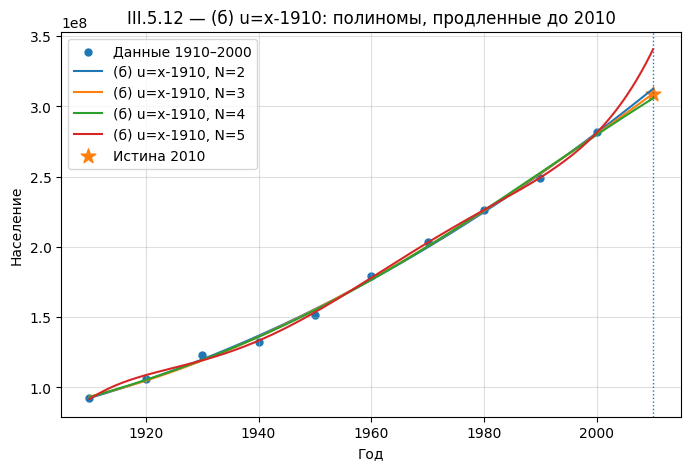

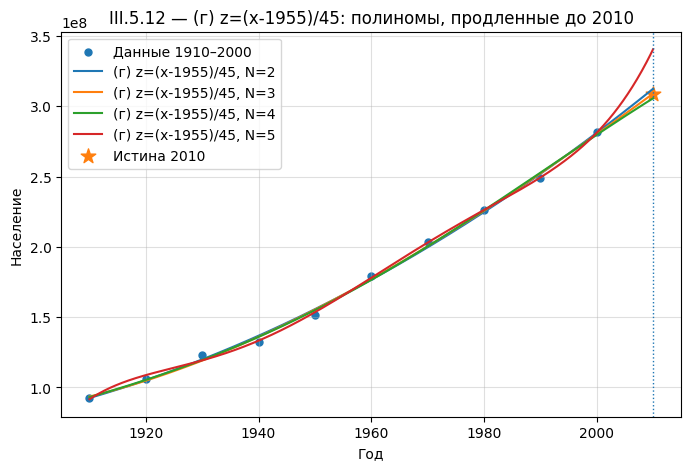

In [26]:
import matplotlib.pyplot as plt

x_dense = np.linspace(years.min(), 2010.0, 1200)

for label, tf in [('(б) u=x-1910', t_b), ('(г) z=(x-1955)/45', t_g)]:
    plt.figure(figsize=(8,5))
    plt.scatter(years, pop, s=25, label='Данные 1910–2000')
    for N in range(2,6):
        coef = results[label][N]['coef']
        y_dense = design_matrix(x_dense, N, tf) @ coef
        plt.plot(x_dense, y_dense, label=f'{label}, N={N}')
    
    plt.axvline(2010, linestyle=':', linewidth=1)
    plt.scatter([2010], [true_2010], marker='*', s=120, label='Истина 2010')
    plt.xlabel('Год'); plt.ylabel('Население')
    plt.title(f'III.5.12 — {label}: полиномы, продленные до 2010')
    plt.grid(True, alpha=0.4); plt.legend()
    plt.show()
